In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import TetrodeUtils as tu
import GeneralUtils as gu
import VideoUtils as vu
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import entropy
import peakutils

In [2]:
def returnPeakIndices(vals, m, t):
     ind_peaks = peakutils.indexes(vals, thres=t, min_dist=m)
     ind_troughs = peakutils.indexes(vals*-1, thres=t, min_dist=m)
     return ind_peaks, ind_troughs

def returnSpikeLocations(spikes, moving):
  global ts
  moving = []
  stopped = []

  for spike in spikes:
    closest_t = gu.take_Closest(ts, spike)
    indx  = np.where(ts == closest_t)[0][0]
    #print("i {}".format(x[i]))
    if indx in imoving:
      moving.append(indx)
    else:
      stopped.append(indx)
  
  return moving,stopped

def plotRasters(goal_starts, goal_stops, gs, col): 
  #the following finds trajectories starting from goal
  #global spikes, cum_t, xsmooth
  for trajectory, goal in enumerate(goal_starts):
    ax = plt.subplot(gs[trajectory,col])  
    goal_stop = np.where(goal_stops>goal)[0]
    if len(goal_stop) > 0:
      rest_one = rests[goal]
      rest_two = rests[goal_stops[goal_stop[0]]]
      ##traj_start and traj_stop are times of arrival at goals
      traj_start = cum_t[rest_one[-1]]
      traj_stop = cum_t[rest_two[0]]
      #print("start {}; stop {}".format(traj_start, traj_stop))
      lapspikes = [spike for spike in spikes if traj_start < spike < traj_stop]
      moving,stopped = returnSpikeLocations(lapspikes, imoving)
      #print("Trajectory duration: {}".format(traj_stop-traj_start))
      #print("Trajectory: {}; spikes: {}".format(trajectory, len(moving)))
    raster = np.zeros(len(moving))

    for i, spike in enumerate(moving):
      raster[i] = x[spike]

    plt.eventplot(raster, linewidths=5, color = 'k')
    plt.xlim([0,65])
    
    plt.axis('off')
    
    

In [4]:
##main program
#pvdfile = sys.argv[1]
#tfilename = sys.argv[2]

pvdfile = './RawData/maze_trackerout.pvd'
tfilename = './RawData/Sc4_03.t64'

spikes = tu.readTFile(tfilename)

ts, x, y = vu.readPVDfile(pvdfile)

#8.2 pixels per centimeter
x /= 8.2
smoothfac = 50
xsmooth = np.abs(np.convolve(x, np.ones(smoothfac, dtype=np.int), 
                 'valid'))/smoothfac

#use later to detect direction
#direction = np.where(np.diff(xsmooth)>0, 1, 0)

cum = np.cumsum(np.abs(np.diff(xsmooth)))
cum_t = np.linspace(ts[0], ts[-1], num=len(cum))

inotmoving = np.where(np.diff(cum)<.1)[0]
imoving = np.where(np.diff(cum)>=.1)[0]

#plt.plot(cum_t,cum)
#plt.plot(cum_t[inotmoving], cum[inotmoving], 'r.')
#plt.show()

nspikes in tfile: 4833


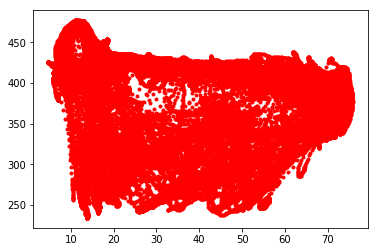

In [5]:
plt.plot(x, y, 'r.')
plt.show()

In [6]:
#find the times where the rat is not moving by
#grouping the consective not moving indices

In [7]:
rests = gu.group_consecutives(inotmoving)

starts = []
stops = []
seq = []

for rest in rests:
   #take a maximum of 100 samples at the rest point
   #note this kicks out a warning sometimes; mean of empty slices
   endpt = rest[0]+100 if rest[-1]-rest[0] > 100 else rest[-1]
   
   if np.mean(xsmooth[rest[0]:endpt]) > 60:
      #print("Goal 1")
      seq.append(1)
   elif np.mean(xsmooth[rest[0]:endpt]) < 8:
      #print("Goal 2")
      seq.append(2)
   else:
      #print("Middle!")
      seq.append(0)

seq = np.asarray(seq)
goal_ones = np.where(seq==1)[0]
goal_twos = np.where(seq==2)[0]

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#Find clean goal ones (where

In [8]:
clean_goal_ones = []

#print(goal_ones)
#print(goal_twos)
#print(np.shape(goal_ones))
#print(np.shape(goal_twos))

for g2 in goal_twos:
  indx = np.where(goal_ones<g2)
  if len(indx[0])>0:
     clean_goal_ones.append(goal_ones[indx[0][-1]])  

g1s = np.unique(clean_goal_ones)
#print(g1s)

NameError: name 'g2s' is not defined

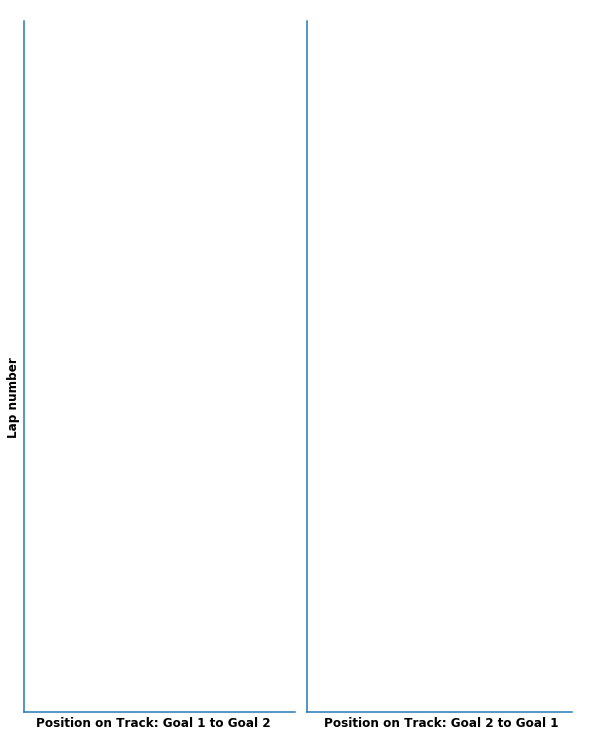

In [9]:
  
fig = plt.figure(figsize=(8,10))
#x0, x1  y0, y1
left_vertical  = mlines.Line2D([0.03,0.03], [0.02,.98], 
                               transform=fig.transFigure, figure=fig)

center_vertical  = mlines.Line2D([.52,.52], [0.02,.98], 
                                 transform=fig.transFigure, figure=fig)
left_base = mlines.Line2D([.03,.5], [.02,.02], 
            transform=fig.transFigure, figure=fig)

right_base = mlines.Line2D([.52,.98], [.02,.02], 
            transform=fig.transFigure, figure=fig)

fig.lines.extend([left_vertical, center_vertical,left_base, right_base])

fig.text(.05, .0, "Position on Track: Goal 1 to Goal 2", 
         fontsize=12, fontweight='bold')
fig.text(.55, .0, "Position on Track: Goal 2 to Goal 1",
         fontsize=12, fontweight='bold')

fig.text(.0, .5, "Lap number", 
          fontsize=12, fontweight='bold', rotation='vertical')

maxtraj = len(g1s) if len(g1s) > len(g2s) else len(g2s)
print(maxtraj)

fig.text(.0, .97, "1", 
          fontsize=12, fontweight='bold', )

fig.text(.0, .02, "{}".format(maxtraj), 
          fontsize=12, fontweight='bold', )

gs = GridSpec(maxtraj,2)
gs.update(hspace=0.01, wspace=0.01,
          left=0.01, right=0.99, 
          top = 0.98, bottom = 0.02 )

#print(g1s)
#print(g2s)

plotRasters(g1s,g2s, gs,0)

plotRasters(g2s, g1s, gs,1) 
plt.show()
tfilename +="RASTER.png"  
fig.savefig(tfilename, dpi='figure')